In [ ]:
import os
os.system("""wget "https://getfile.dokpub.com/yandex/get/https://disk.yandex.com/d/dS1nPF0JXFToNA" -O ReadMe_en_.zip""")
os.system("unzip /content/ReadMe_en_.zip -d /content")

0

In [ ]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from torch.utils.data import DataLoader, SequentialSampler

from transformers import BertForSequenceClassification
import pandas as pd
import numpy as np


from transformers import XLMRobertaTokenizer
from transformers import XLMRobertaForSequenceClassification

In [ ]:
model = XLMRobertaForSequenceClassification.from_pretrained('/content/ReadMe_en_roberta',
                                                      num_labels=6,
                                                      output_attentions=False,
                                                      output_hidden_states=True)

In [ ]:
device = "cpu"
if torch.cuda.is_available(): device = "cuda"

model = model.to(device)

In [ ]:
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base',
                                          do_lower_case=True)
def load_data(language, indixes):
    data = pd.read_excel(f'/content/{language}_data_from_en.xlsx')
    texts = [data.iloc[:, 0][i] for i in indixes]
    labels = [data.iloc[:, 1][i] for i in indixes]

    return (texts, labels)

def make_dataloader(data):

    encoded_data_predict = tokenizer.batch_encode_plus(
        data[0],
        add_special_tokens=True,
        return_attention_mask=True,
        pad_to_max_length=True,
        max_length=512,
        return_tensors='pt'
    )

    input_ids_predict = encoded_data_predict['input_ids']
    attention_masks_predict = encoded_data_predict['attention_mask']
    labels_predict = torch.tensor(data[1])

    dataset_predict = TensorDataset(input_ids_predict, attention_masks_predict, labels_predict)


    batch_size = 3

    return DataLoader(dataset_predict,
                                  sampler=SequentialSampler(dataset_predict),
                                  batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

In [ ]:
def get_neurons_activations(dataloader):
    model.eval()

    # Подготовка списка для хранения усредненных скрытых состояний по слоям
    avg_hidens_per_layer = [[] for _ in range(13)]  # предполагается, что у модели 12 слоев + входной слой

    for batch in dataloader:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        # Создание маски для исключения [PAD] токенов (где input_ids равно 0)
        mask = inputs['input_ids'] != 0  # Создается маска размером как input_ids, True где не PAD
        mask = mask.unsqueeze(-1).expand_as(outputs['hidden_states'][0])  # Расширение маски до размера скрытых состояний

        for layer_idx, layer_hidden_states in enumerate(outputs['hidden_states']):
            # Применение маски к скрытым состояниям
            masked_hidden_states = layer_hidden_states * mask.float()
            # Вычисление суммы и количества не-pad токенов для усреднения
            sum_hidden_states = masked_hidden_states.sum(dim=1)  # Сумма по оси токенов
            non_pad_tokens = mask.sum(dim=1)  # Количество не-pad токенов
            # Усреднение скрытых состояний, исключая pad-токены
            avg_hidden_states = sum_hidden_states / non_pad_tokens.clamp(min=1)  # Избегание деления на 0
            avg_hidens_per_layer[layer_idx].append(avg_hidden_states)

    # Собираем усредненные скрытые состояния по всему датасету для каждого слоя
    avg_hidens_stacked_per_layer = [torch.cat(layer_avg_hidens, dim=0) for layer_avg_hidens in avg_hidens_per_layer]

    # Стекинг усредненных скрытых состояний для всех слоев
    all_avg_hidens_tensor = torch.stack(avg_hidens_stacked_per_layer)

    return all_avg_hidens_tensor # [layers, batch, neurons]


In [ ]:
def pearson_corr(x, y):
    return (torch.dot(x, y)/(torch.norm(x)*torch.norm(y))).item()

def ANC(L1, L2):
    X = L1 - L1.mean(dim=0, keepdim=True)
    Y = L2 - L2.mean(dim=0, keepdim=True)

    anc = 0
    for i in range(X.size()[0]):
        anc += abs(pearson_corr(X[i], Y[i]))

    return anc/X.size()[0]

def count_ANC(layers1, layers2):
    anc = []
    for i in range(13):
        anc.append(ANC(layers1[i], layers2[i]))

    return anc

In [ ]:
import random
n_samples = 50
random_indixes = random.sample(range(296), n_samples)

dataloader_en = make_dataloader(load_data('en', random_indixes))
layers_en = get_neurons_activations(dataloader_en)
torch.cuda.empty_cache()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

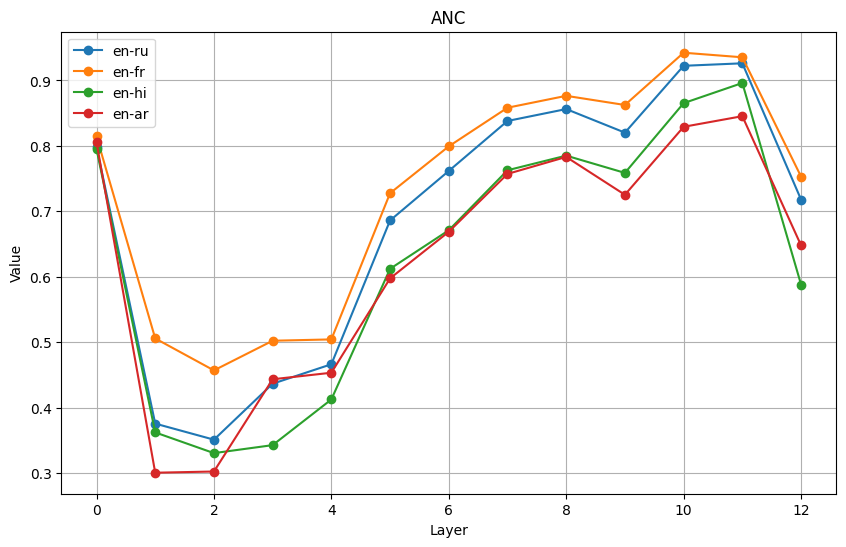

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(0, 13)

plt.figure(figsize=(10, 6))

for lang in ['ru', 'fr', 'hi', 'ar']:
    dataloader_compare = make_dataloader(load_data(lang, random_indixes))
    layers_compare = get_neurons_activations(dataloader_compare)
    torch.cuda.empty_cache()

    ANC_counted = count_ANC(layers_en, layers_compare)

    plt.plot(x, ANC_counted, label=f'en-{lang}', marker='o')

plt.title('ANC')
plt.xlabel('Layer')
plt.ylabel('Value')
plt.legend()

plt.grid(True)
plt.show()


In [ ]:
data_ANC = []
languages = ['ru', 'fr', 'hi', 'ar']

for i in range(10):
    random_indixes = random.sample(range(296), n_samples)

    data = load_data('en', random_indixes)
    dataloader_en = make_dataloader(data)
    layers_en = get_neurons_activations(dataloader_en)
    torch.cuda.empty_cache()

    for lang in languages:
        data = load_data(lang, random_indixes)
        dataloader_compare = make_dataloader(data)
        layers_compare = get_neurons_activations(dataloader_compare)
        torch.cuda.empty_cache()

        ANC_counted = count_ANC(layers_en, layers_compare)

        data_ANC.append({
            'Value': ANC_counted,
            'Language Pair': f'en-{lang}'
        })

df = pd.DataFrame(data_ANC)
df.to_csv(f'ANC_ReadMe.txt', index=False, sep=';')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

In [ ]:
from scipy.stats import wasserstein_distance

def wasserstein(matrix1, matrix2):
    vector1 = matrix1.cpu().numpy().flatten()
    vector2 = matrix2.cpu().numpy().flatten()

    vector1 -= np.mean(vector1, axis=0)
    vector2 -= np.mean(vector2, axis=0)

    distance = wasserstein_distance(vector1, vector2)
    return distance

def count_wasserstein_distance(layers1, layers2):
    dist = []
    for i in range(13):
        dist.append(wasserstein(layers1[i], layers2[i]))

    return dist

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

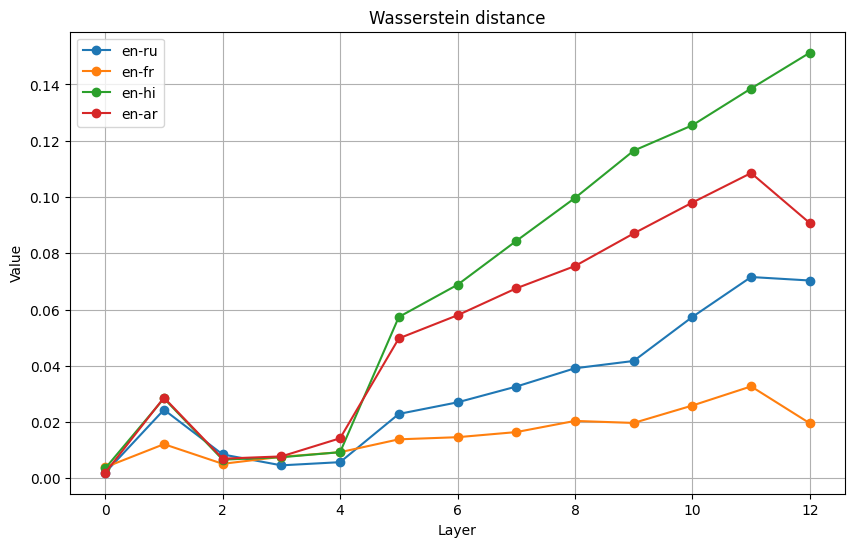

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(0, 13)

plt.figure(figsize=(10, 6))

for lang in ['ru', 'fr', 'hi', 'ar']:
    dataloader_compare = make_dataloader(load_data(lang, random_indixes))
    layers_compare = get_neurons_activations(dataloader_compare)
    torch.cuda.empty_cache()

    wasserstein_distance_counted = count_wasserstein_distance(layers_en, layers_compare)

    plt.plot(x, wasserstein_distance_counted, label=f'en-{lang}', marker='o')

plt.title('Wasserstein distance')
plt.xlabel('Layer')
plt.ylabel('Value')
plt.legend()

plt.grid(True)
plt.show()


In [ ]:
data_wasserstein = []

for i in range(10):
    random_indixes = random.sample(range(296), n_samples)

    data = load_data('en', random_indixes)
    dataloader_en = make_dataloader(data)
    layers_en = get_neurons_activations(dataloader_en)
    torch.cuda.empty_cache()

    for lang in languages:
        data = load_data(lang, random_indixes)
        dataloader_compare = make_dataloader(data)
        layers_compare = get_neurons_activations(dataloader_compare)
        torch.cuda.empty_cache()

        wasserstein_distance_counted = count_wasserstein_distance(layers_en, layers_compare)

        data_wasserstein.append({
            'Value': wasserstein_distance_counted,
            'Language Pair': f'en-{lang}'
        })

df = pd.DataFrame(data_wasserstein)
df.to_csv(f'wasserstein_ReadMe.txt', index=False, sep=';')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 